In [1]:
import pandas as pd
import json
import os
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

root_file = './CLEAN_DB_VERSIONS/CLEAN_DB_FOR_GNN/'
train = pd.read_csv(os.path.join(root_file, 'train.txt'), header=None, names=['h', 'r', 't'])
test = pd.read_csv(os.path.join(root_file, 'test.txt'), header=None, names=['h', 'r', 't'])
map_ = pd.read_csv(os.path.join(root_file, 'DB_Bert_Emb_INT__MAPPING.csv'))
db2index = dict(zip(map_.DB_ID, map_.INDEX))
index2db = dict(zip(map_.INDEX, map_.DB_ID))
emb_ = pd.read_csv(os.path.join(root_file, 'DB_Bert_Emb_INT.csv'))
mapping = {}
for i, row in emb_.iterrows():
    mapping[row['DB_ID']] = row[:-1].values
db_ids = db2index.keys()
assert len(set(index2db.keys()).difference(train['h'].unique().tolist()+train['t'].unique().tolist()+test['h'].unique().tolist()+test['t'].unique().tolist())) == 0

In [2]:
print("UNIQUE NODES: %d" % (len(db2index)))

UNIQUE NODES: 3679


In [3]:
import tqdm
import random
import faiss                   # make faiss available
import numpy as np
from faiss import pairwise_distances


X_all = []
for _, row in emb_.iterrows():
    X_all.append(row.values[:-1].reshape(-1))
X_all = np.ascontiguousarray(np.array(X_all), dtype=np.float32)
dim_size = row[:-1].values.size
index = faiss.IndexFlatL2(dim_size)   # build the index
index.add(X_all)
distances = pairwise_distances(X_all, X_all)

In [4]:
pairs = train['h'].astype(str) + '_' + train['t'].astype(str)
x_train_pairs = list(set(pairs))
print(len(pairs), len(x_train_pairs))

pairs = test['h'].astype(str) + '_' + test['t'].astype(str)
x_test_pairs = list(set(pairs))
print(len(pairs), len(x_test_pairs))

290722 290722
1004167 1004167


In [5]:
import numpy as np
def get_sparsity(A):
    return 1.0 - ( np.count_nonzero(A) / float(A.size) )

# Adj matrix (train)

adj_train = np.zeros((len(db_ids), len(db_ids)), dtype=np.int8)
for item in x_train_pairs:
    splits = item.split("_")
    try:
        adj_train[int(splits[0]), int(splits[1])] = 1
    except KeyError:
        continue
        
        
print("Sparsity Train: %0.2f%%"%(100*get_sparsity(adj_train)))

adj_test = np.zeros((len(db_ids), len(db_ids)), dtype=np.int8)
for item in x_test_pairs:
    splits = item.split("_")
    try:
        adj_test[int(splits[0]), int(splits[1])] = 1
    except KeyError:
        continue

print("Sparsity Test: %0.2f%%"%(100*get_sparsity(adj_test)))

adj_all = np.zeros_like(adj_train, dtype=np.int8)
adj_all = adj_train + adj_test
adj_all = np.clip(adj_all, 0, 1)
print("Sparsity Total: %0.2f%%"%(100*get_sparsity(adj_all)))

Sparsity Train: 97.85%
Sparsity Test: 92.58%
Sparsity Total: 90.43%


In [6]:
labels = distances*(adj_train + adj_test)
labels[labels>0] = 1
labels = labels.astype(np.int8, copy=False)
print("Sparsity of labels: %0.2f %%" % (100*get_sparsity(labels)))

Sparsity of labels: 90.43 %


# Get classification results for the dummy cases. a) All test yes, b) Random

In [7]:
def show_metrics_pos(y_true, y_score, wanted_indexes=None, print_=True, neg_label=0, pos_label=1):
    if wanted_indexes:
        y_true = y_true[wanted_indexes]
        y_score = y_score[wanted_indexes]
    if neg_label != 0:
        y_true[y_true==neg_label] = 0
        y_score[y_score==neg_label] = 0
    if pos_label != 1:
        y_true[y_true==pos_label] = 1
        y_score[y_score==pos_label] = 1
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # False negative
    fn = np.sum(y_true * (y_score==0))
    # tn
    tn = np.sum((y_true == 0) * (y_score==0))
    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # Precision
    precision = tp / (tp + fp)
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
#     print("True positive: ", tp)
#     print("False positive: ", fp)
#     print("False negative: ", fn)
    if print_:
        print("True positive: ", tp)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True negative: ", tn)
        print("Total #: ", tp + fp +fn +tn)
        print("True positive rate (recall): ", tpr)
        print("Precision: ", precision)
        print("F1: ", f1)
    return precision, tpr, f1

## a) All test yes

In [8]:
adj_all_yes = np.ones_like(adj_test)
_, _, _ = show_metrics_pos(adj_test.ravel(), adj_all_yes.ravel())

True positive rate (recall):  1.0
Precision:  0.07419017053587056
F1:  0.13813228340911005


## b) Random

In [9]:
# Get average over N-runs
pre, rec, f1 = 0, 0, 0
n_runs = 10
for i in tqdm_notebook(range(n_runs)):
    adj_random = np.random.random(adj_test.shape)
    adj_random[adj_random>=0.5] = 1
    adj_random[adj_random<0.5] = 0
    p, r, f = show_metrics_pos(adj_test.ravel(), adj_random.ravel(), print_=False)
    pre += p
    rec += r
    f1 += f
print("True positive rate (recall): ", rec/float(n_runs))
print("Precision: ", pre/float(n_runs))
print("F1: ", f1/float(n_runs))


True positive rate (recall):  0.5002484646478126
Precision:  0.07422279761459145
F1:  0.1292661357592212


# Get popular model

Text(1060, 0.6000000000000001, '90.00% at \n1160 drugs')

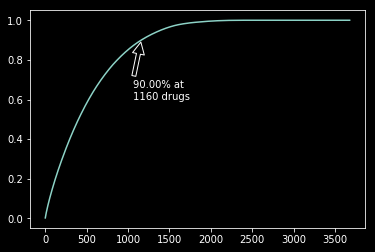

In [82]:
pop_ = np.sum(adj_train, axis=0)/float(np.sum(adj_train))
pop_sum = np.cumsum(np.sort(pop_)[::-1])

plt.plot(pop_sum)
tr = 0.9
ind = np.argwhere(pop_sum >= tr)[0][0]
plt.annotate('%0.2f%% at \n%d drugs' % (100*tr, ind), xy=(ind, tr), xytext=(ind-100, tr-0.3), arrowprops=dict(facecolor='black', shrink=0.05),)

In [83]:
# Keep indexes of wanted drugs
indexes_of_popular_drugs = np.argsort(pop_)[::-1][:ind]
adj_popular = np.zeros_like(adj_test)
# All rows of these drugs are 1s
adj_popular[indexes_of_popular_drugs,:] = 1
# assert for sanity
assert ind*len(adj_popular) == adj_popular.sum()
# Symmetrize
adj_popular = adj_popular + adj_popular.T - np.diag(adj_popular.diagonal())
show_metrics_pos(adj_test.ravel(), adj_popular.ravel())

True positive rate (recall):  0.7473604724283993
Precision:  0.10333168504778466
F1:  0.18156042999913732


(0.10333168504778466, 0.7473604724283993, 0.18156042999913732)

## Plot F1-score as function of the number of the kept models

In [54]:
# Keep indexes of wanted drugs
logs = []
for i in tqdm_notebook(np.linspace(1, len(db2index), num=100)):
    indexes_of_popular_drugs = np.argsort(pop_)[::-1][:int(i)]
    adj_popular = np.zeros_like(adj_test)
    # All rows of these drugs are 1s
    adj_popular[indexes_of_popular_drugs,:] = 1
    # assert for sanity
    assert int(i)*len(adj_popular) == adj_popular.sum()
    # Symmetrize
    adj_popular = adj_popular + adj_popular.T - np.diag(adj_popular.diagonal())
    logs.append(list(show_metrics_pos(adj_test.ravel(), adj_popular.ravel(), print_=False)) + [i, i/float(len(db2index)), pop_sum[int(i)-1]])

Text(0, 0.5, 'Score')

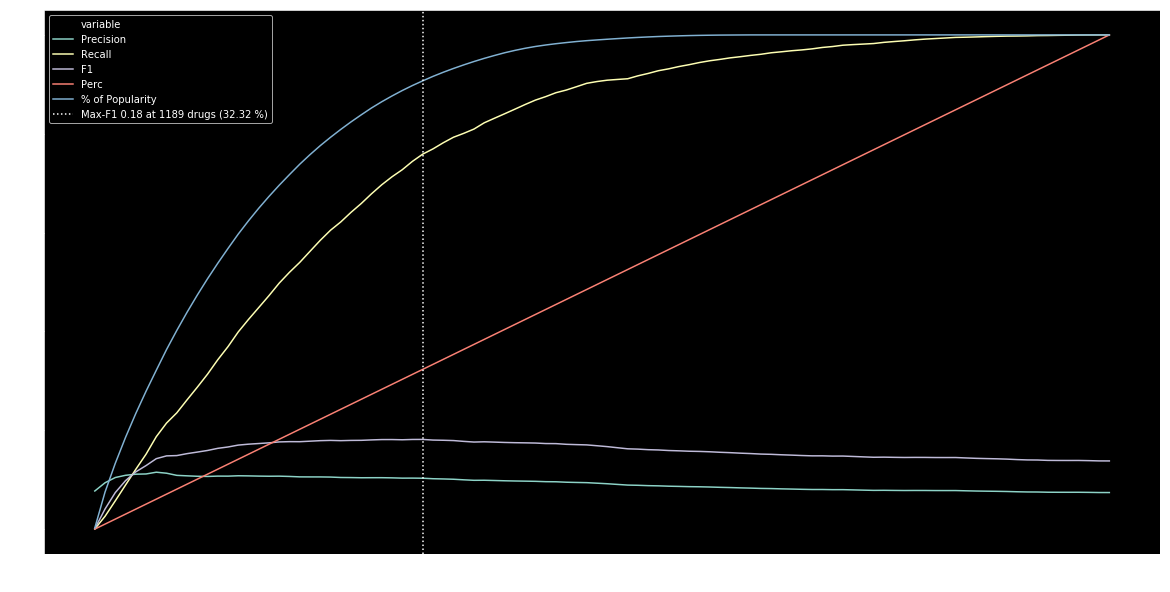

In [81]:
import seaborn as sns
df = pd.DataFrame(logs, columns=['Precision', 'Recall', 'F1', 'number', 'Perc', '% of Popularity'])
plt.figure(figsize=(20, 10))
max_f1_ind = int(df[df.F1 == df.F1.max()]['number'].values[0])
sns.lineplot(x='number', y='value', hue='variable', data=df.melt(id_vars='number'))
plt.axvline(max_f1_ind, label='Max-F1 %0.2f at %d drugs (%0.2f %%)' % (df.F1.max(), max_f1_ind, 100*max_f1_ind/float(len(db2index))), linestyle=':')
plt.xlabel('# of drugs')
plt.legend()
plt.ylabel('Score')

# Get distances model

A) Simple distance with threshold on train

True positive rate (recall):  0.11935265747629627
Precision:  0.11458855
F1:  0.11692209534931025


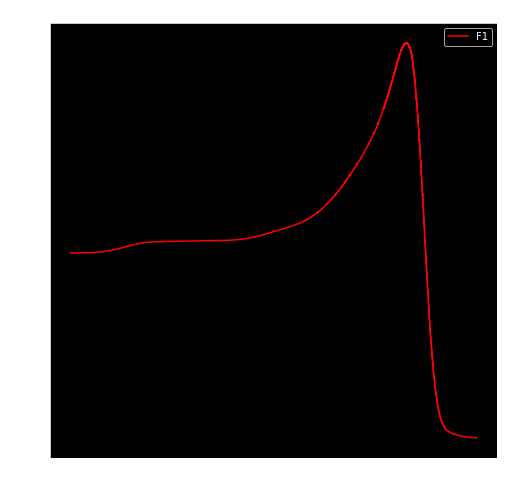

In [25]:
# logs = []
# for tr in tqdm_notebook(np.linspace(np.min(distances), np.max(distances), num=100)):
#     cur_adj = []
#     show_metrics_pos(adj_test.ravel(), adj_popular.ravel())
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve

# Transform to probas
similarities = 1-MinMaxScaler().fit_transform(distances.copy())
# Calculate tresholds with precision and recalls
p, r, thresholds = precision_recall_curve(adj_train.ravel(), similarities.ravel())
# Calculate f1s
f1s = 2*p*r/(p+r+0.0001)
# Find optimal treshold
tr = thresholds[np.argmax(f1s[:-1])]

plt.figure(figsize=(8, 8))
plt.plot(thresholds, f1s[:-1], "r-", label="F1")
plt.ylabel("Score")
plt.xlabel("Decision Threshold")
plt.legend(loc='best')
plt.title("With threshold %0.2f that gives %0.2f F1 at train edges." % (tr, np.max(f1s)))

# Binarize
similarities[similarities>=tr] = 1
similarities[similarities<tr] = 0

_, _, _ = show_metrics_pos(adj_test.ravel(), similarities.ravel())

## B) Use Training

In [24]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=10, random_state=42)

In [90]:
mapping[list(mapping.keys())[0]]

array([ 2.02024865e-01, -6.61715079e-03, -9.94127381e-02,  4.85000873e-02,
        6.05207460e-02, -7.30205952e-02, -9.06812540e-02, -2.69626984e-04,
        1.51755873e-02, -7.29187778e-02,  2.63782762e-01,  2.25907024e-01,
       -2.83020873e-01,  2.57151810e-01, -1.78660103e-01, -2.78132944e-01,
       -3.70900159e-02, -1.19716294e-01, -7.02006190e-02, -2.27242937e-02,
       -3.47451270e-02, -2.86983095e-02, -1.64769825e-01,  1.43449619e-01,
       -7.83596032e-03, -1.05877206e-01,  1.30941730e-01,  5.24169167e-01,
       -1.81395056e-01,  3.74518056e-01,  9.19123968e-02, -9.36110952e-02,
        7.19366032e-02, -4.05477143e-02,  2.66929063e-01, -4.25460000e-02,
        3.87222143e-02,  1.40661683e-01, -1.59230563e-01, -1.41271952e-01,
        2.48533548e-01, -1.00296190e-01,  9.23658413e-02, -3.84166270e-02,
       -1.90164063e-01, -3.19672738e-01,  2.10879524e-02,  2.26722770e-01,
       -2.50554079e-01, -6.19702540e-02,  2.33460714e-02,  2.43744063e-01,
        1.02087714e-01, -

In [7]:
# Efficient sampling procedure

In [8]:
import numpy as np
def negsamp_vectorized_bsearch_preverif(pos_inds, n_items, n_samp=32):
    """ Pre-verified with binary search
    `pos_inds` is assumed to be ordered
    """
    raw_samp = np.random.randint(0, n_items - len(pos_inds), size=n_samp)
    pos_inds_adj = pos_inds - np.arange(len(pos_inds))
    neg_inds = raw_samp + np.searchsorted(pos_inds_adj, raw_samp, side='right')
    return neg_inds

In [9]:
def show_metrics_pos(y_true, y_score, wanted_indexes=None, print_=True, neg_label=0, pos_label=1):
    if wanted_indexes:
        y_true = y_true[wanted_indexes]
        y_score = y_score[wanted_indexes]
    if neg_label != 0:
        y_true[y_true==neg_label] = 0
        y_score[y_score==neg_label] = 0
    if pos_label != 1:
        y_true[y_true==pos_label] = 1
        y_score[y_score==pos_label] = 1
    # True positive
    tp = np.sum(y_true * y_score)
    # False positive
    fp = np.sum((y_true == 0) * y_score)
    # False negative
    fn = np.sum(y_true * (y_score==0))
    # tn
    tn = np.sum((y_true == 0) * (y_score==0))
    # True positive rate (sensitivity or recall)
    tpr = tp / (tp + fn)
    # Precision
    precision = tp / (tp + fp)
    # F1 score
    f1 = 2*tp / (2*tp + fp + fn)
#     print("True positive: ", tp)
#     print("False positive: ", fp)
#     print("False negative: ", fn)
    if print_:
        print("True positive: ", tp)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True negative: ", tn)
        print("Total #: ", tp + fp +fn +tn)
        print("True positive rate (recall): ", tpr)
        print("Precision: ", precision)
        print("F1: ", f1)
    return precision, tpr, f1

In [11]:
def minibatch_test(x_test_pairs, adj_all, mapping, model, minibatch_size=1000, print_progress=True, add_negatives=True, ns_samples=1):
    N_batches = int(len(x_test_pairs)/minibatch_size)
    #print(N_batches)
    prec, rec, f1 = [], [], []
    if not(print_progress):
        for i_batch in range(0, N_batches):
            #print(i_batch)
            #print(i_batch*N_batches, i_batch*N_batches + minibatch_size)
            cur_batch = x_test_pairs[i_batch*N_batches:i_batch*N_batches + minibatch_size]
            #print(cur_batch)
            X_cur = []
            y_cur = []
            for str_item in cur_batch:
                item = str_item.split('_')
                item = [float(i) for i in item]
                X_cur.append(np.concatenate([mapping[item[0]], mapping[item[1]]]).reshape(1,-1))
                y_cur.append(1)
                if add_negatives:
                        # Current index of head triple
                    head_ind = int(item[0])
                    # Positive linkgs of this triple
                    pos_ind = np.argwhere(adj_all[head_ind]>0).flatten()
                    # Negative sampled links
                    neg_ind = negsamp_vectorized_bsearch_preverif(pos_ind, len(adj_all), ns_samples)
                    #print(neg_ind)
                    for neg_item in neg_ind: 
                        try:
                            X_cur.append(np.concatenate([mapping[item[0]], mapping[float(neg_item)]]).reshape(1,-1))
                            y_cur.append(-1)
                        except KeyError:
                            continue
                        except IndexError:
                            continue
            X_cur = np.array(X_cur).reshape(len(X_cur), -1)
            y_pred = model.predict(X_cur)
            p, r, f = show_metrics_pos(np.array(y_cur).ravel(), y_pred.ravel(), print_=False, neg_label=-1, pos_label=1)
            #print(p,r,f)
            from collections import Counter
            #print(Counter(y_cur))
            #print(Counter(y_pred))
            prec.append(p)
            rec.append(r)
            f1.append(f)
    else:
        for i_batch in tqdm_notebook(range(0, N_batches)):
            #print(i_batch)
            #print(i_batch*N_batches, i_batch*N_batches + minibatch_size)
            cur_batch = x_test_pairs[i_batch*N_batches:i_batch*N_batches + minibatch_size]
            #print(cur_batch)
            X_cur = []
            y_cur = []
            for str_item in cur_batch:
                item = str_item.split('_')
                item = [float(i) for i in item]
                X_cur.append(np.concatenate([mapping[item[0]], mapping[item[1]]]).reshape(1,-1))
                y_cur.append(1)
                if add_negatives:
                        # Current index of head triple
                    head_ind = int(item[0])
                    # Positive linkgs of this triple
                    pos_ind = np.argwhere(adj_all[head_ind]>0).flatten()
                    # Negative sampled links
                    neg_ind = negsamp_vectorized_bsearch_preverif(pos_ind, len(adj_all), ns_samples)
                    #print(neg_ind)
                    for neg_item in neg_ind: 
                        try:
                            X_cur.append(np.concatenate([mapping[item[0]], mapping[float(neg_item)]]).reshape(1,-1))
                            y_cur.append(-1)
                        except KeyError:
                            continue
                        except IndexError:
                            continue
            X_cur = np.array(X_cur).reshape(len(X_cur), -1)
            y_pred = model.predict(X_cur)
            print(y_pred)
            print(y_cur)
            print(X_cur)
            p, r, f = show_metrics_pos(np.array(y_cur).ravel(), y_pred.ravel(), print_=False, neg_label=-1, pos_label=1)
            print(p,r,f)
            from collections import Counter
            #print(Counter(y_cur))
            #print(Counter(y_pred))
            prec.append(p)
            rec.append(r)
            f1.append(f)
        #print(prec, rec, f1)
    return np.mean(prec), np.mean(rec), np.mean(f1)

In [13]:
def check_early_stopping(hist_max, hist_est, current_value, cur_est, tol_count, tolerance=4):
    from copy import deepcopy
    if current_value > hist_max:
        print("%0.2f %% --> %0.2f %% Keeping new model" % (100*hist_max, 100*current_value))
        return current_value, deepcopy(cur_est), 0, False
    elif current_value <= hist_max:
        tol_count += 1
        if tol_count < tolerance:
            print('No change! Early stopping: %d/%d' % (tol_count, tolerance))
            return hist_max, hist_est, tol_count, False
        else:
            print("Early stopping reached!")
            return hist_max, hist_est, tol_count, True

In [19]:
import random
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report, f1_score, confusion_matrix

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

est = SGDClassifier(loss='hinge',  n_jobs=1,
                    warm_start=True,
                    learning_rate='constant',
                    eta0 = 0.00001,
                    penalty='l2',
                    random_state=random_seed,
                    tol=0e-3)

X_train = []
ns_samples = 1
cor_strategy = "both" # could be head or tail
print_every = 10000
train_every = 5000
logs = []
c = 0
X_cur_train = []
y_cur_train = []
use_weights = True
best_score = 0
best_model = None
tol_count = 0
tolerance = 3
if use_weights:
    pos_weight = 1 - get_sparsity(adj_train)
for str_item in x_train_pairs:
    item = str_item.split('_')
    item = [float(i) for i in item]
    c += 1
    if c % print_every == 0 and c >= print_every:
        print("$$$$$$$$$    Report     $$$$$$$$$")
        print("We are at: %d %0.2f%%"%(c, 100*c/float(len(x_train_pairs))))
        prec, rec, f1 = minibatch_test(x_test_pairs[:10000], adj_all, mapping, est, minibatch_size=1000, print_progress=False)
        f1_train = f1_score(y_train_true, y_train_pred)
        best_score, best_model, tol_count, early_stop = check_early_stopping(best_score, best_model, f1_train, est, tol_count, tolerance)
        print("TRAIN BATCH F1: %0.2f%% "%(100*f1_train))
        print("TEST F1: %0.2f%% "%(100*f1))
        logs.append({'Step':c, 'Prec':prec, 'Rec':rec,'F1':f1, 'F1-Train':f1_train})
        print("$$$$$$$$$$$$$$$$$"*4 + '\n')
        if early_stop:
            est = best_model
            break
            
    try:
        X_cur_train.append(np.concatenate([mapping[item[0]], mapping[item[1]]]).reshape(1,-1))
        y_cur_train.append(1)
        #est.partial_fit(X_cur, [1],classes=[-1, 1])
    except KeyError:
        continue
    # Current index of head triple
    head_ind = int(item[0])
    # Positive linkgs of this triple
    pos_ind = np.argwhere(adj_train[head_ind]>0).flatten()
    # Negative sampled links
    neg_ind = negsamp_vectorized_bsearch_preverif(pos_ind, len(adj_train), ns_samples)
    #print(neg_ind)
    for neg_item in neg_ind: 
        try:
            X_cur_train.append(np.concatenate([mapping[item[0]], mapping[float(neg_item)]]).reshape(1,-1))
            y_cur_train.append(-1)
        except KeyError:
            continue
        except IndexError:
            continue
    if len(X_cur_train) >= train_every:
        X_cur_train = np.array(X_cur_train).reshape( len(X_cur_train), -1)
        y_cur_train = np.array(y_cur_train).ravel()
        from sklearn.utils import shuffle
        X_cur_train, y_cur_train = shuffle(X_cur_train, y_cur_train)
        if use_weights:
            weights = pos_weight * np.ones_like(y_cur_train)
            weights[weights < 0] = 1-pos_weight
            est.partial_fit(X_cur_train, y_cur_train, [-1, 1], sample_weight=weights)
            y_train_pred = est.predict(X_cur_train).ravel()
            y_train_true = y_cur_train.ravel()
        else:
            est.partial_fit(X_cur_train, y_cur_train, [-1, 1])
            y_train_pred = est.predict(X_cur_train).ravel()
            y_train_true = y_cur_train.ravel()
        #from collections import Counter
        #Counter(y_cur_train)
        X_cur_train = []
        y_cur_train = []
        weights = []
        

$$$$$$$$$    Report     $$$$$$$$$
We are at: 10000 3.44%
0.00 % --> 58.68 % Keeping new model
TRAIN BATCH F1: 58.68% 
TEST F1: 41.32% 
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

$$$$$$$$$    Report     $$$$$$$$$
We are at: 20000 6.88%
No change! Early stopping: 1/3
TRAIN BATCH F1: 58.60% 
TEST F1: 40.49% 
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

$$$$$$$$$    Report     $$$$$$$$$
We are at: 30000 10.32%
58.68 % --> 59.14 % Keeping new model
TRAIN BATCH F1: 59.14% 
TEST F1: 41.98% 
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

$$$$$$$$$    Report     $$$$$$$$$
We are at: 40000 13.76%
59.14 % --> 61.17 % Keeping new model
TRAIN BATCH F1: 61.17% 
TEST F1: 42.71% 
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

$$$$$$$$$    Report     $$$$$$$$$
We are at: 50000 17.20%
No change! Early stopping: 1/3
TRAIN BATCH F1: 61.07% 
TEST F1: 43.69% 
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

KeyboardInterrupt: 

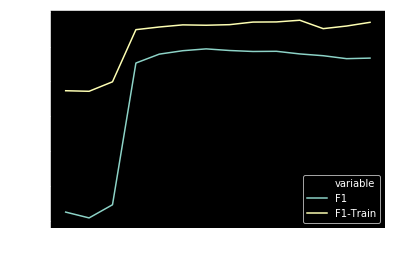

In [16]:
import seaborn as sns
df = pd.DataFrame(logs)
#df.F1.plot()
#plt.show()
sns.lineplot(x='Step', y='value', hue='variable', data=df.drop(['Prec', 'Rec'], axis=1).melt('Step'))

In [17]:
#Print Total Result
X_est = []
c = 0
est_every = 10000
y_pred = []
for i in tqdm_notebook(range(len(adj_all))):
    for j in range(len(adj_all)):
        X_est.append(np.concatenate([mapping[float(i)], mapping[float(j)]]).reshape(1,-1))
        c += 1
        if c == est_every:
            X_est = np.array(X_est).reshape(len(X_est), -1)
            y_pred.extend(est.predict(X_est).ravel().tolist())
            c = 0
            X_est = []
# For what's left
if c > 0:
    X_est = np.array(X_est).reshape(len(X_est), -1)
    y_pred.extend(est.predict(X_est).ravel().tolist())
    c = 0
    X_est = []

In [136]:
show_metrics_pos(adj_test.ravel(), np.array(y_pred).reshape(adj_all.shape).ravel(), pos_label=1, neg_label=-1)

True positive:  455235
False positive:  5286273
False negative:  548932
True negative:  7244601
Total #:  13535041
True positive rate (recall):  0.45334590760301824
Precision:  0.0792884029770576
F1:  0.13497092581542988


(0.0792884029770576, 0.45334590760301824, 0.13497092581542988)

In [162]:
# This is with positive weights
show_metrics_pos(adj_test.ravel(), np.array(y_pred).reshape(adj_all.shape).ravel(), pos_label=1, neg_label=-1)

True positive:  591524
False positive:  7075354
False negative:  412643
True negative:  5455520
Total #:  13535041
True positive rate (recall):  0.5890693480267725
Precision:  0.07715317760371301
F1:  0.13643661173480243


(0.07715317760371301, 0.5890693480267725, 0.13643661173480243)

In [16]:
# This is with warm start jobs=1 pos_weights reversed (could use early stopping on the features)
show_metrics_pos(adj_test.ravel(), np.array(y_pred).reshape(adj_all.shape).ravel(), pos_label=1, neg_label=-1)

True positive:  664463
False positive:  7834428
False negative:  339704
True negative:  4696446
Total #:  13535041
True positive rate (recall):  0.6617056724628473
Precision:  0.07818231814009616
F1:  0.13984193298620295


(0.07818231814009616, 0.6617056724628473, 0.13984193298620295)

In [18]:
# with early stopping weighting with large the positive samples
show_metrics_pos(adj_test.ravel(), np.array(y_pred).reshape(adj_all.shape).ravel(), pos_label=1, neg_label=-1)

True positive:  853391
False positive:  10398594
False negative:  150776
True negative:  2132280
Total #:  13535041
True positive rate (recall):  0.8498496763984477
Precision:  0.07584359559668805
F1:  0.13925920631532637


(0.07584359559668805, 0.8498496763984477, 0.13925920631532637)